In [1]:
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import normalize
from sklearn.metrics import f1_score
import scipy.stats as stats
import scipy.sparse as sparse

import time
import random
import seaborn

from tqdm.notebook import trange, tqdm

from numpy.random import default_rng

import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Configure Matplotlib for high-quality output
plt.rcParams.update({
    'font.size': 12,              # Set the font size
    'axes.labelsize': 12,        # Set the label size
    'axes.titlesize': 14,        # Set the title size
    'xtick.labelsize': 10,       # Set the x-axis tick label size
    'ytick.labelsize': 10,       # Set the y-axis tick label size
    'axes.linewidth': 1.2,      # Set the axis linewidth
    'lines.linewidth': 1.5,     # Set the line thickness
    'patch.linewidth': 1.2,     # Set the patch (e.g., rectangle) linewidth
    'xtick.major.width': 1.2,   # Set the major x-axis tick linewidth
    'ytick.major.width': 1.2,   # Set the major y-axis tick linewidth
    'xtick.minor.width': 1.0,   # Set the minor x-axis tick linewidth
    'ytick.minor.width': 1.0,   # Set the minor y-axis tick linewidth
    'xtick.major.size': 6,      # Set the major x-axis tick size
    'ytick.major.size': 6,      # Set the major y-axis tick size
    'xtick.minor.size': 4,      # Set the minor x-axis tick size
    'ytick.minor.size': 4,      # Set the minor y-axis tick size
    'axes.labelweight': 'bold', # Set label weight to bold
    'axes.titleweight': 'bold', # Set title weight to bold
    'axes.grid': True,          # Display gridlines
    'grid.linestyle': '--',     # Set gridline style
    'grid.alpha': 0.7,          # Set gridline transparency
    'savefig.dpi': 300,         # Set the resolution for saving figures
    'figure.figsize': (16, 9),   # Set the default figure size
})

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Reshape, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.losses import mean_squared_error

In [4]:
import numpy as np
import tensorflow as tf

def flatten(model):
    if not model.built:
        # Ensure the model is built by calling it with a batch of dummy data
        _ = model(np.zeros((1, 3), dtype=np.float32))
    flattened_vars = np.concatenate([tf.reshape(var, [-1]) for var in model.trainable_variables])
    return flattened_vars

def unflatten_trainable_variables(flattened_vars, model):
    if not model.built:
        # Ensure the model is built by calling it with a batch of dummy data
        _ = model(np.zeros((1, 3), dtype=np.float32))
    shapes = [var.shape.as_list() for var in model.trainable_variables]
    start = 0
    for i, shape in enumerate(shapes):
        size = np.prod(shape)
        flat_var = tf.reshape(flattened_vars[start:start+size], shape)
        flat_var = tf.cast(flat_var, tf.float32)  # Ensure the same data type
        model.trainable_variables[i].assign(flat_var)
        start += size

def tf_flatten(gradients):
    w_dense = []

    for l in gradients:
        w_dense += l.numpy().flatten().tolist()
    return np.array(w_dense)

def sparse_weight(model, delta):
    flatten_weight = flatten(model)
    flatten_weight = flatten_weight * delta
    unflatten_trainable_variables(flatten_weight, model)


## Data Generation

In [5]:
N_m = 5000

def u_star(x, t):
    return np.sin(x)*np.exp(-k*t)

In [6]:

k = 0.5
L = np.pi
rng = default_rng(seed=42)


T_end= 1

x_vals = rng.uniform(0, L, N_m)
t_vals = rng.uniform(0, T_end, N_m)

x_vals_sensor = rng.uniform(0, L, N_m)
t_vals_sensor = rng.uniform(0, T_end, N_m)
u_true = u_star(x_vals_sensor, t_vals_sensor) 

noise_level = 0.10

mea_sig = noise_level*np.std(u_true)

y_obs_int = u_true + rng.normal(0, mea_sig, u_true.shape)



In [7]:
N_sb = 128
N_tb = 128

# boundary condition when t = 0 and t = 1
t_vals_tb = np.random.choice([0,1], N_tb, replace=True)
x_vals_tb = rng.uniform(0, L, N_tb)
u_vals_tb = u_star(x_vals_tb, t_vals_tb) 

# boundary condition when x = 0 or L
t_vals_sb = rng.uniform(0, 1, N_sb)
x_vals_sb = np.array([0]*(N_sb//2) + [L]*(N_sb//2))
u_vals_sb = u_star(x_vals_sb, t_vals_sb)

In [8]:
# interior points 
N_int = int(100**2)
x_vals = rng.uniform(0, L, N_int)
t_vals = rng.uniform(0, T_end, N_int)

In [9]:
N_int

10000

In [10]:
d_tb = np.column_stack((x_vals_tb, t_vals_tb, u_vals_tb))
d_sb = np.column_stack((x_vals_sb, t_vals_sb, u_vals_sb))
data = np.column_stack((x_vals_sensor, t_vals_sensor, y_obs_int))
inter = np.column_stack((x_vals, t_vals))



In [11]:
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.initializers import HeNormal,GlorotUniform

def get_pred_nn(hsize=[64]):
    #initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1)
    initializer = GlorotUniform()
    #initializer = HeNormal()

    model = Sequential()
    model.add(Dense(hsize[0], input_shape=(2,), kernel_initializer=initializer))
    model.add(Activation('tanh'))   
    
    model.add(Dense(hsize[0],kernel_initializer=initializer))
    model.add(Activation('tanh'))   
    
    model.add(Dense(hsize[0], kernel_initializer=initializer))
    model.add(Activation('tanh'))  
    
    model.add(Dense(hsize[0], kernel_initializer=initializer))
    model.add(Activation('tanh'))  
    
    model.add(Dense(1, activation='linear'))  
 
    return model

In [12]:
def polynomial_decay_lr(iteration, init_lr, gamma=0.01, aa=0.9, update_interval=10):
    """
    Calculate the learning rate using a polynomial decay scheme based on the current iteration number.

    :param iteration: Current iteration number.
    :param init_lr: Initial learning rate.
    :param gamma: Positive constant controlling the decay rate.
    :param alpha: Controls the shape of the decay curve.
    :param update_interval: Interval at which the learning rate is updated.
    :return: Updated learning rate.
    """

    if iteration % update_interval == 0:
        return init_lr / (1 + gamma * (iteration // update_interval))**aa
    else:
        # Return the previous learning rate if not an update interval
        return init_lr / (1 + gamma * ((iteration - 1) // update_interval))**aa


In [13]:
pp = len(flatten(get_pred_nn()))

In [14]:
N_M = y_obs_int.shape[0]


In [15]:
N_int

10000

In [16]:
nn_net = get_pred_nn()
#nn_net.load_weights('./Example1_Weight_1024')



In [17]:
mea_sig**2

0.0006354438853316014

In [18]:
pp

12737

In [19]:
N_M

5000

In [20]:
#batch size
#BB_M = 200
#BB_int = 200
#here lamb is the parameter we interested in (lambda)
loss_hist = []
lamb_hist = []
sparsity_hist = []
alpha = 1.0

##


sig_M2 = mea_sig**2
sig_R2 = 1
sig_B2 = 1

#Init Delta
delta = np.random.choice([0,1], (pp,), p = [0.0,1.0],replace=True)

uu = 1.1
JJ = int(0.02*pp)
rho_0 = (N_M)
rho_1 = 1

rho = 1

#store theta and lambda along the way
thetas_list = []
delta_list = []
lamb_hist_keep = []


def train(epochs):
    global delta
    nn_net = get_pred_nn()
    temp_net = get_pred_nn()
    
    init_lr = 1e-8
    lr = init_lr
    
    lamb = np.random.normal(0, 1)
    
    tf_u_sb =  tf.convert_to_tensor(d_sb[:,2:], dtype=tf.float32)
    tf_u_tb = tf.convert_to_tensor(d_tb[:,2:], dtype=tf.float32)
            
        
    tf_mea = tf.stack([data[:,0], data[:,1]], axis=1)
    tf_y_obs = tf.convert_to_tensor(data[:,2:], dtype=tf.float32)
            
    
            
    tf_input_sb = tf.stack([d_sb[:,0], d_sb[:,1]], axis=1)
    tf_input_tb = tf.stack([d_tb[:,0], d_tb[:,1]], axis=1)
    

    
    for ii in tqdm(range(1, epochs+1)):
        #random_indices = np.random.choice(N_int, size=sample_N_int, replace=False)
        
        #tf_x_int = tf.stack([inter[random_indices,0], inter[random_indices,1]], axis=1)
        #tf_x_int = tf.cast(tf_x_int, dtype=tf.float32)
        
        # Sparsify the weight to get theta_delta
        sparse_weight(nn_net, delta)
    
        # Find log-likelihood l(theta_delta) 

        
        #lr = polynomial_decay_lr(ii, init_lr, update_interval=500)
        
        
        with tf.GradientTape(persistent=True) as t: 
            term1 = -tf.reduce_mean((tf_y_obs - nn_net(tf_mea))**2) / (2*sig_M2)                    
            loss =  N_M*(term1) 
        
        loss_hist.append(loss.numpy())
        gradients = t.gradient(loss, nn_net.trainable_variables)
        
        
        # Update theta_bar
        flat_gradient = tf_flatten(gradients)
        flat_theta = flatten(nn_net)


        delta_comp = 1-delta
        
        rand_sample = rng.normal(0, 1/np.sqrt(rho_0),len(delta_comp))
        rand_stdnorm = rng.normal(0,1, len(delta_comp))
        
        flat_theta += (rand_sample*delta_comp ) 
        
        update_term = lr*(-rho_1*flat_theta + flat_gradient) + np.sqrt((2*lr))*rand_stdnorm
        update_term *= delta
        
        flat_theta += update_term
               
        theta_bar = flat_theta
        
        # Update delta with theta and lambda
        aa = uu*np.log(pp)+0.5*np.log(rho_0 / rho_1)       
        
        sparsity_hist.append(np.sum(delta) / pp)
        
        idces = rng.choice(len(delta), JJ, replace=False)
        delta[idces] = 0
        
        
        flat_theta_bar_nu = flat_theta*delta
        unflatten_trainable_variables(flat_theta_bar_nu, temp_net)
        
        
        with tf.GradientTape(persistent=True) as t: 
            term1 = -tf.reduce_mean((tf_y_obs - temp_net(tf_mea))**2) / (2*sig_M2)                      

            loss =  N_M*(term1) 
        temp_grad = t.gradient(loss, temp_net.trainable_variables)
        flat_temp_grad = tf_flatten(temp_grad)
        
        temp_term = aa + 0.5*(rho_1-rho_0)*(flat_theta**2)-flat_theta*flat_temp_grad-0.5*(flat_theta**2)*(flat_temp_grad**2) 
        temp_qq = 1 / (1 + np.exp(temp_term) )
        temp_bin = rng.binomial(1,temp_qq)     
        delta[idces] = temp_bin[idces]

        # Assign temp_value to next iter
        unflatten_trainable_variables(theta_bar, nn_net)
        
            
        if ii % (epochs //10) == 0:
            print(lr)
            
            plt.plot(loss_hist[-(epochs //10):])
            plt.show()  
        
            plt.plot(sparsity_hist[-(epochs //10):])
            plt.show()
            
            print('----------------------------')
        
        
        
        if ii >= (epochs - 200000) and ii % 20 == 0:
            delta_list.append(delta)
            thetas_list.append(theta_bar)
 
    
    return nn_net

    

  0%|          | 0/1000000 [00:00<?, ?it/s]

1e-08


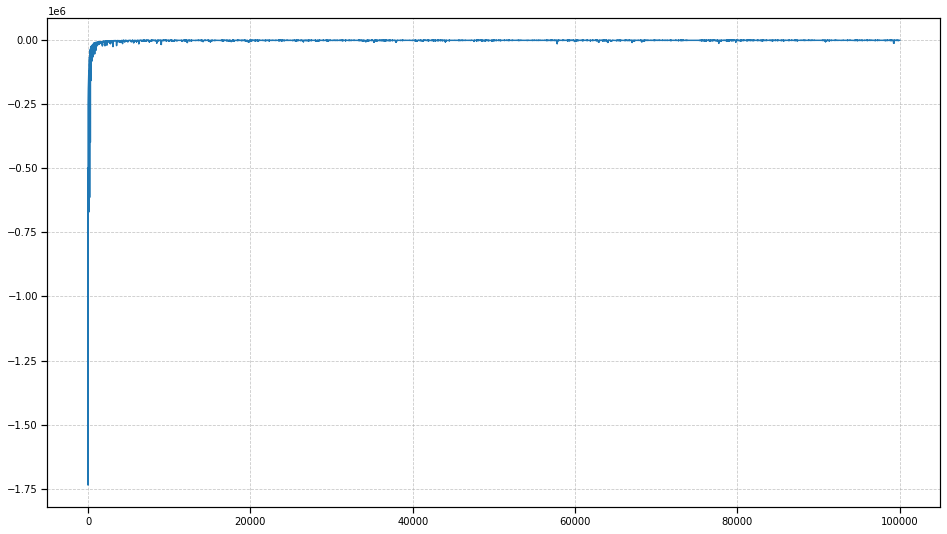

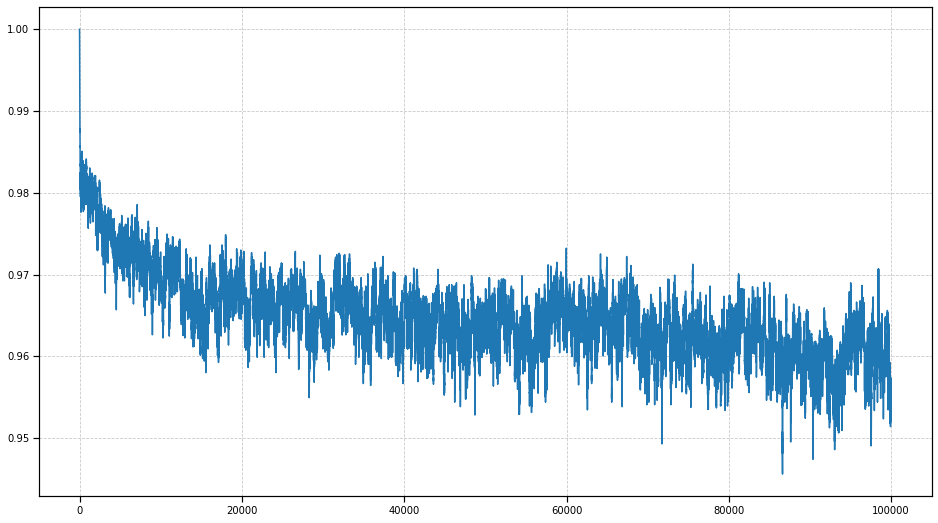

----------------------------
1e-08


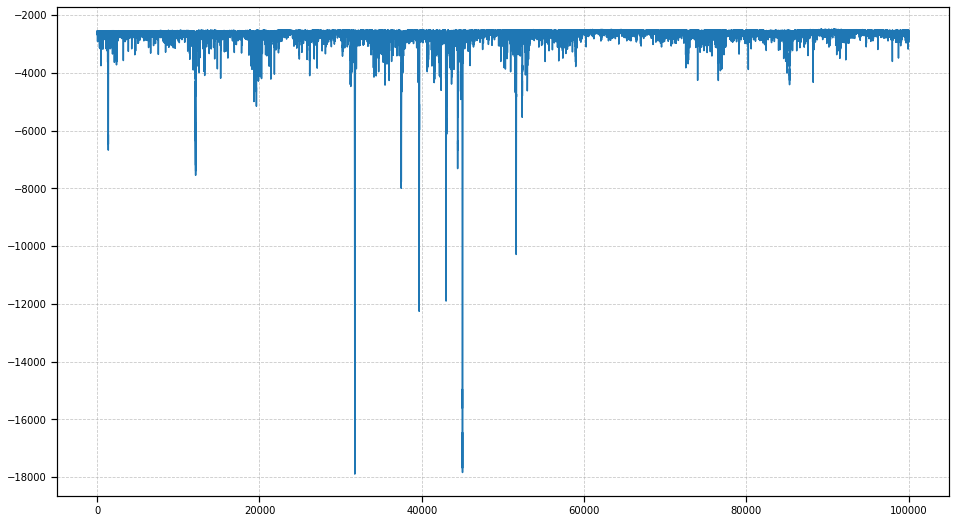

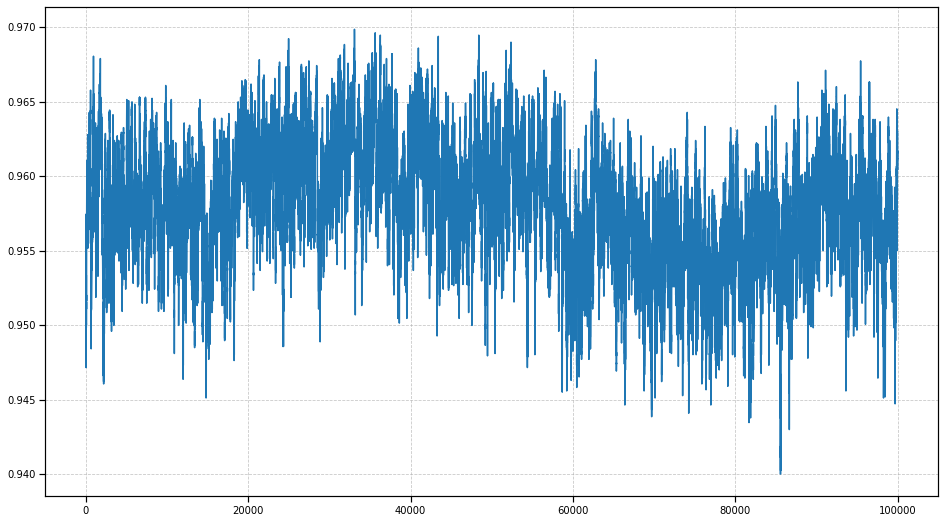

----------------------------
1e-08


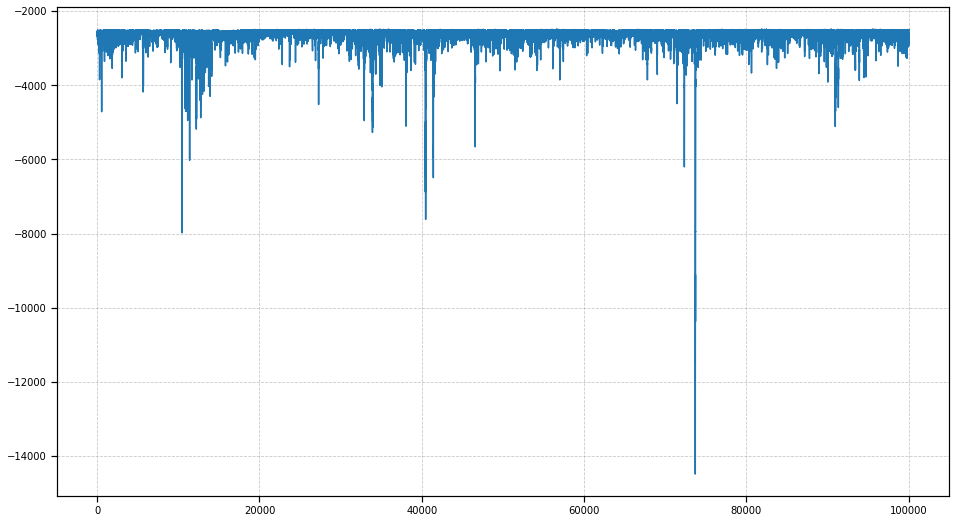

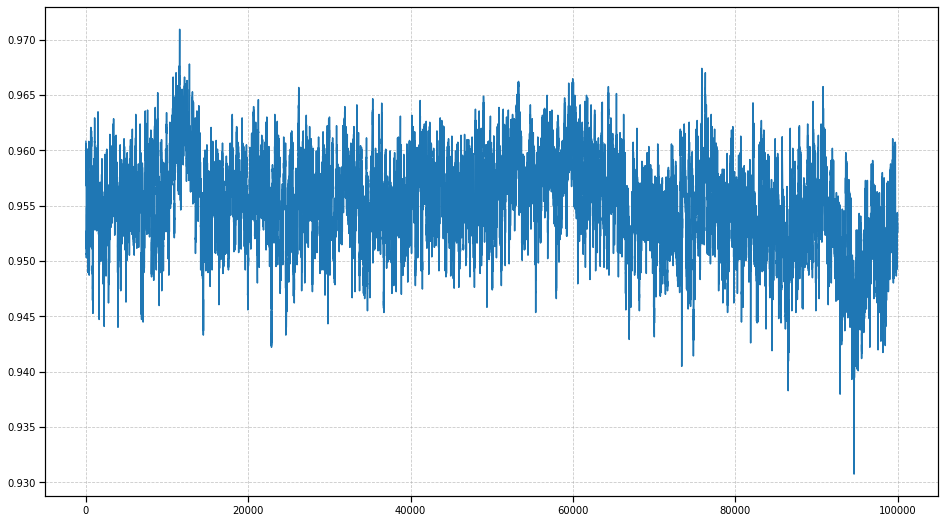

----------------------------
1e-08


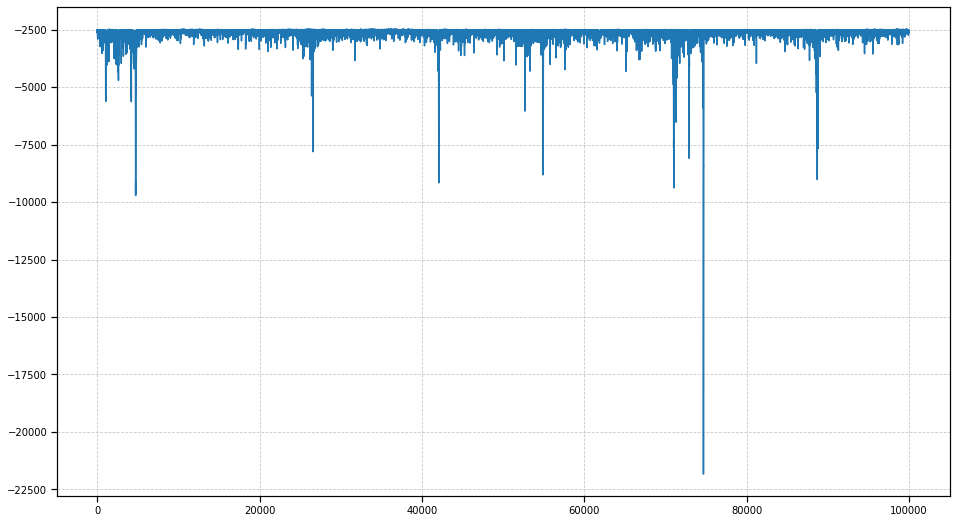

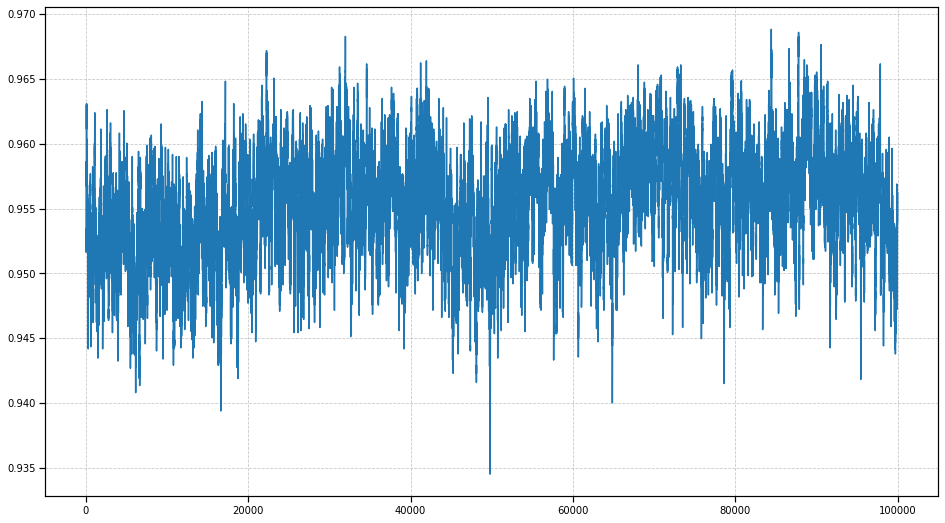

----------------------------
1e-08


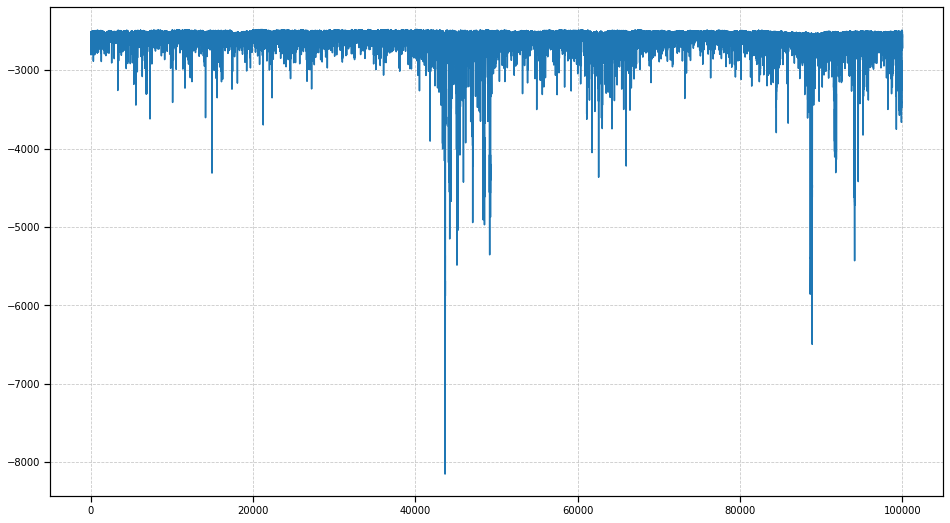

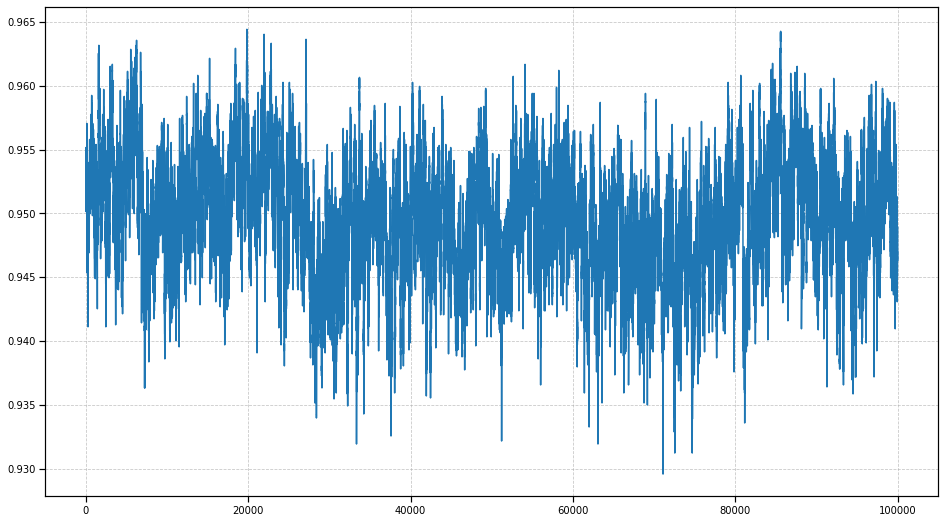

----------------------------
1e-08


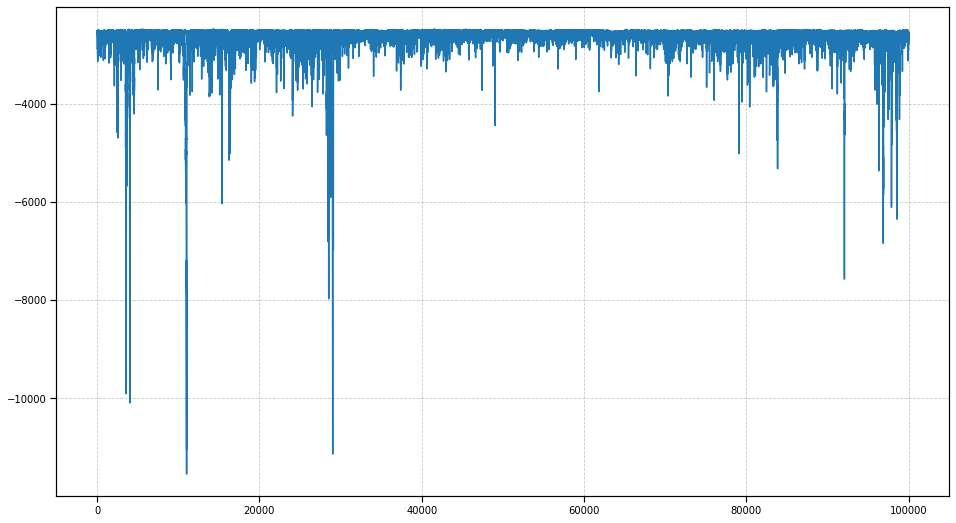

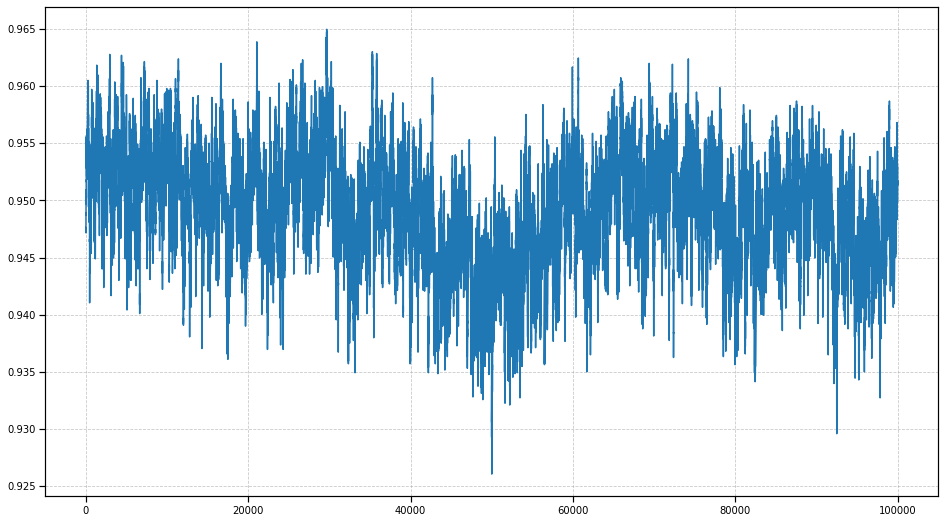

----------------------------
1e-08


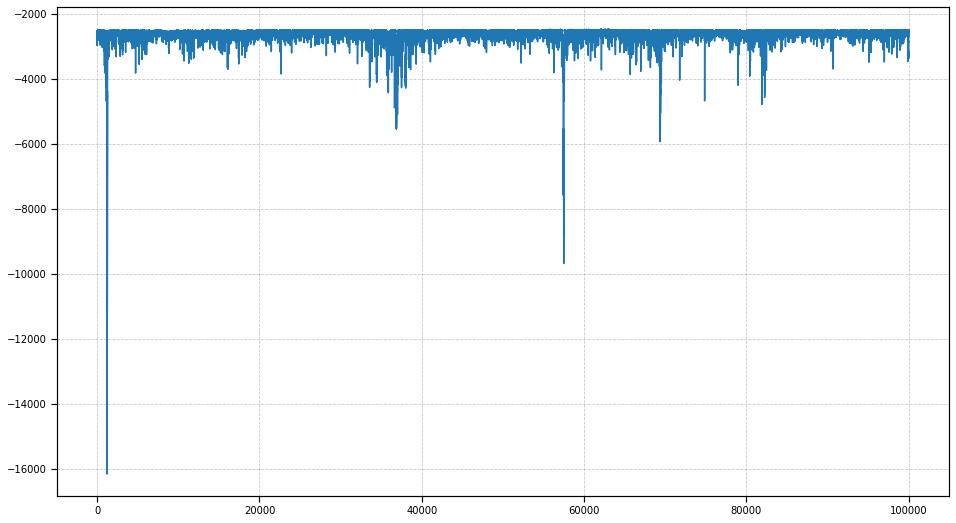

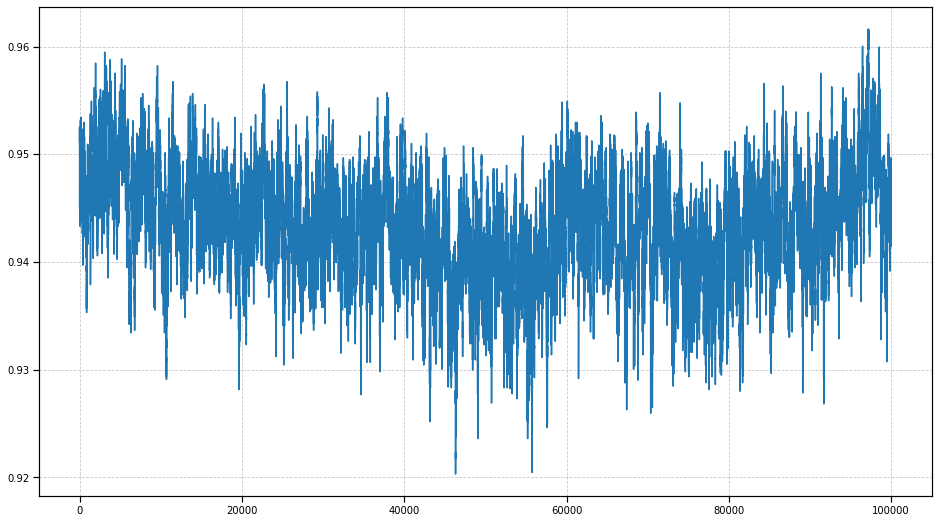

----------------------------
1e-08


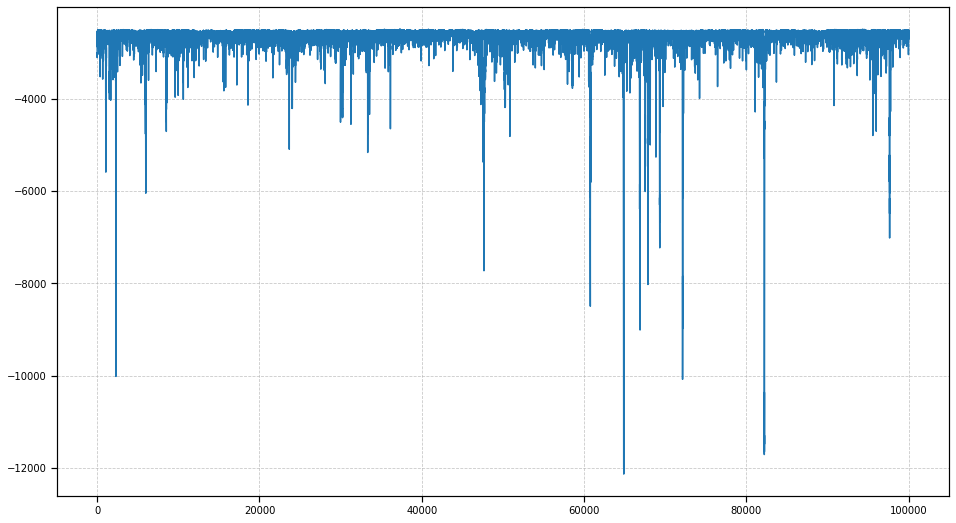

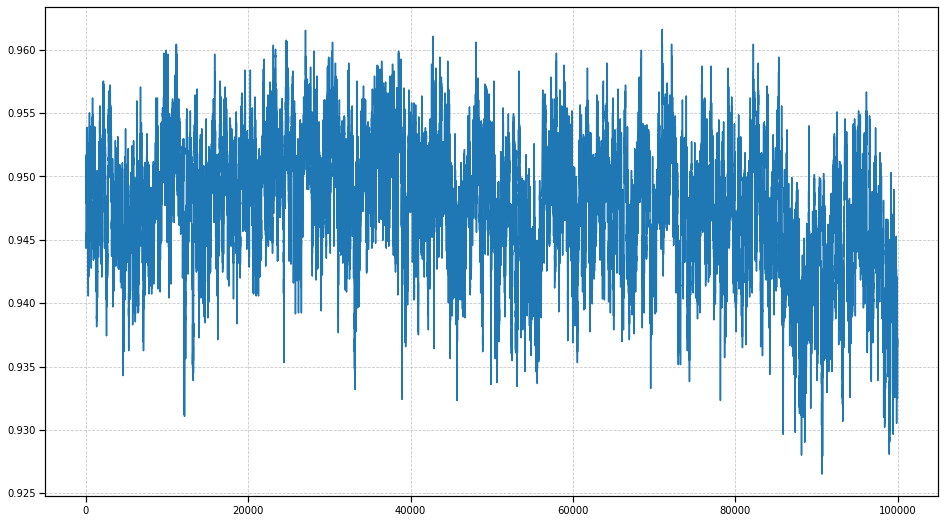

----------------------------
1e-08


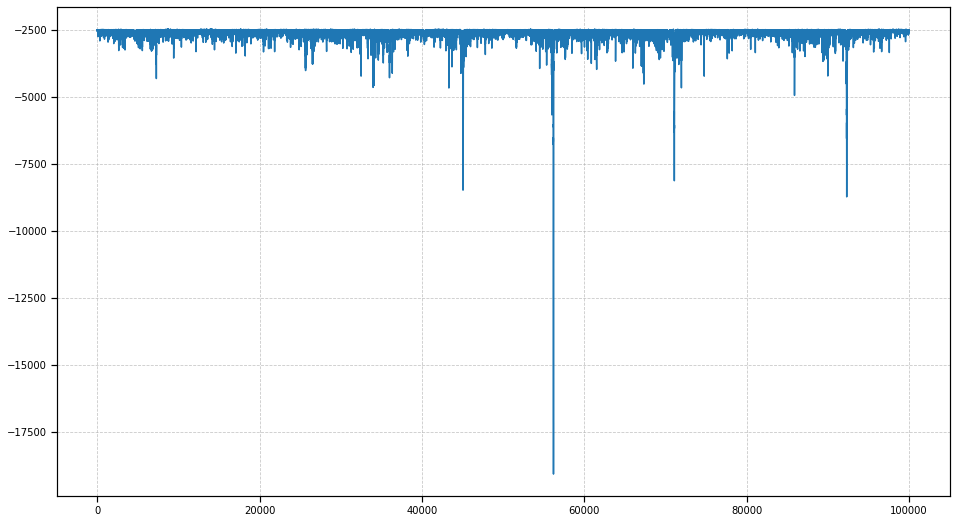

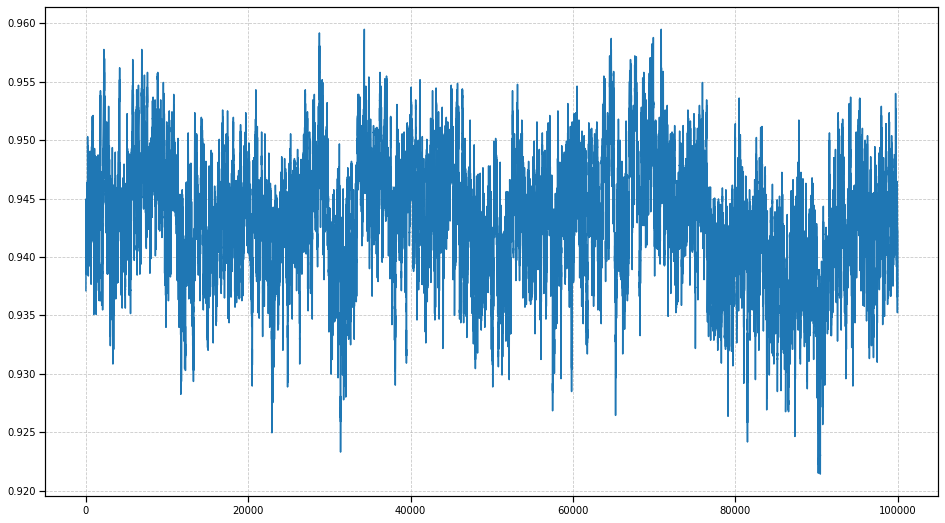

----------------------------
1e-08


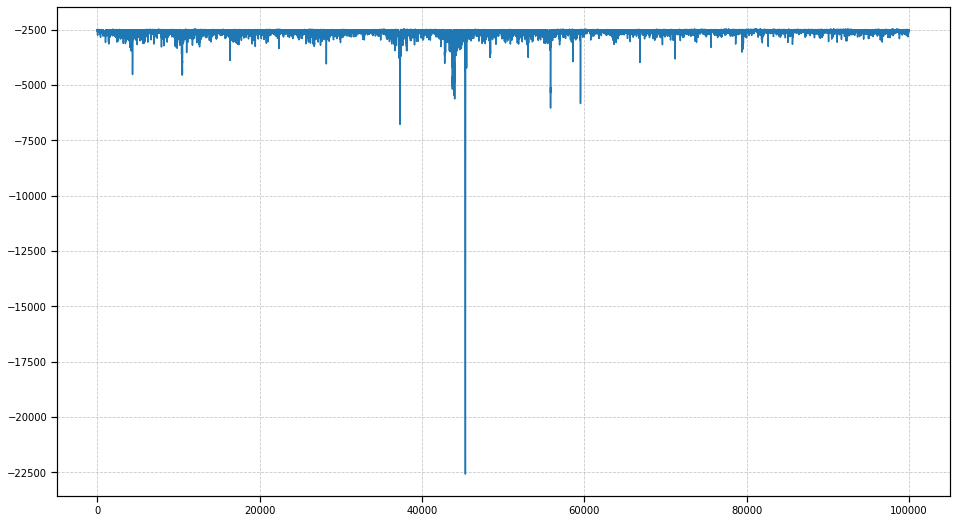

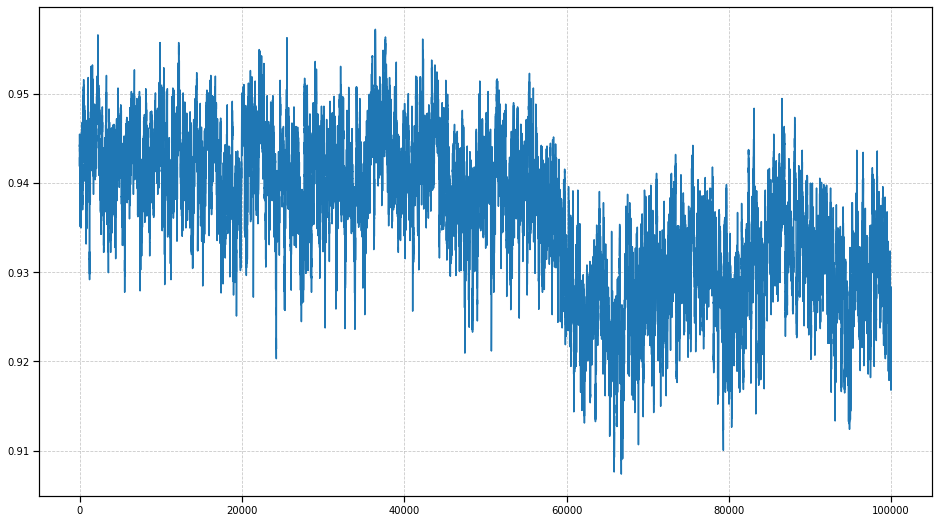

----------------------------


In [21]:
numIterK = 1000000

with tf.device('/gpu:0'):
    nn_net = train(epochs=numIterK)

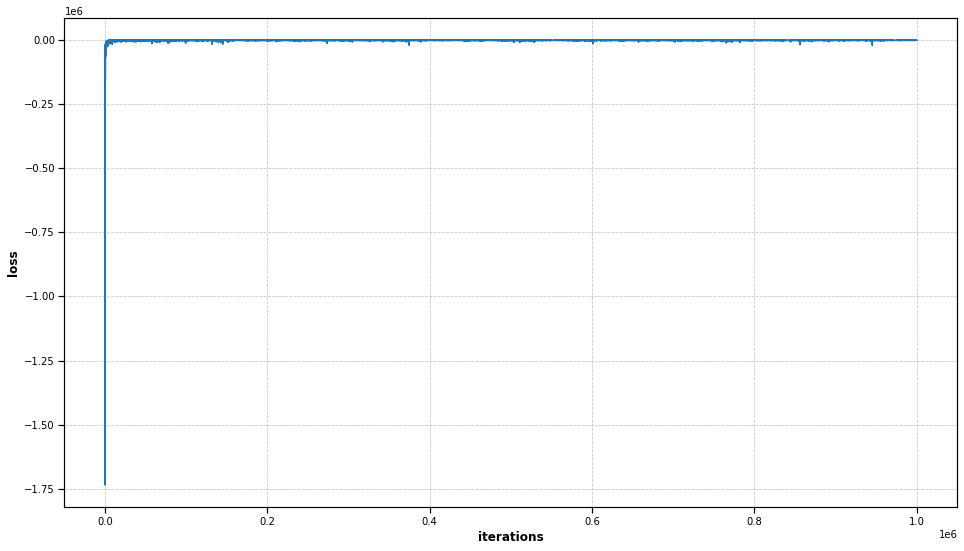

In [22]:
plt.plot(loss_hist)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

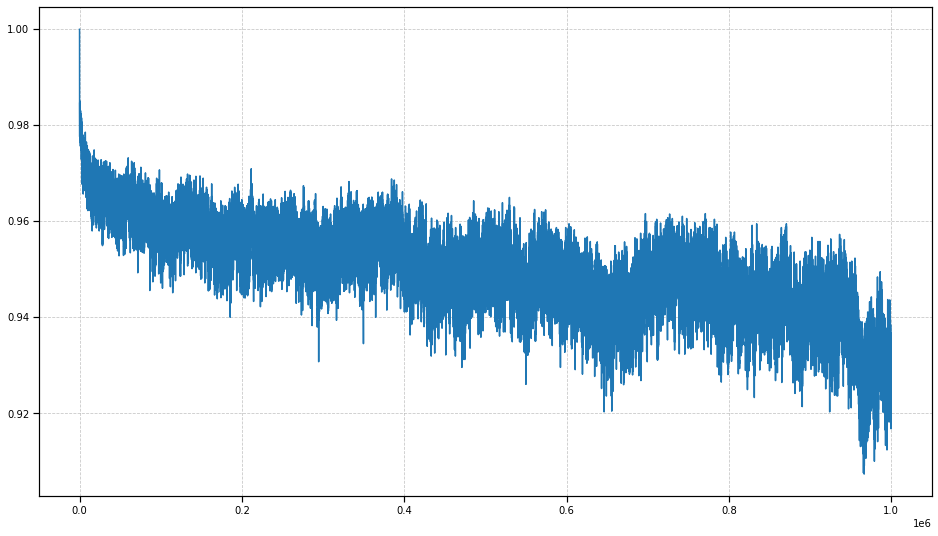

In [23]:
plt.plot(sparsity_hist)
plt.show()
        

In [24]:
np.mean(sparsity_hist[-200000::20])

0.9398467535526419

In [25]:
#lambda_sample = []
theta_sample = []
delta_sample = []
for ii in range(len(thetas_list)):
    if ii>=0 and ii % 1 == 0:
        #lambda_sample.append(lamb_hist_keep[ii])
        theta_sample.append(thetas_list[ii])
        delta_sample.append(delta_list[ii])

In [26]:
lambda_sample = []
nn_net_i = get_pred_nn()
tf_x_int = tf.stack([inter[:,0], inter[:,1]], axis=1)
tf_x_int = tf.cast(tf_x_int, dtype=tf.float32)
tf_x_int = tf.Variable(tf_x_int, trainable=True)
for ii in trange(len(theta_sample)):
    theta_i = theta_sample[ii] 
    delta_i = delta_sample[ii]
    unflatten_trainable_variables(theta_i, nn_net_i)
    sparse_weight(nn_net_i, delta_i)
    with tf.GradientTape(persistent=True) as t_2:
        with tf.GradientTape(persistent=True) as t_1:
            out = nn_net_i(tf_x_int)
        du_xt = t_1.gradient(out, tf_x_int)
        du_dt = du_xt[:,1]
        du_dx = du_xt[:,0]
    du_dxdx = t_2.gradient(du_dx, tf_x_int)[:, 0]
    temp_X = tf.stack([du_dxdx],1).numpy()
    temp_Y = tf.stack([du_dt],1).numpy()
   
    temp_Sigma0_inv = rho
    temp_SigR2_inv = (N_M**alpha)/(N_int*sig_R2)

    sample_Sig_inv = temp_SigR2_inv * (temp_X.T)@temp_X + temp_Sigma0_inv

    sample_Sig = 1/(sample_Sig_inv)
    sample_mu = temp_SigR2_inv * sample_Sig@(temp_X.T@temp_Y)
    
    py_mu = sample_mu.flatten()
    py_Sigma = sample_Sig

    temp_lamb = rng.multivariate_normal(py_mu, py_Sigma)[0] 
        
    lambda_sample.append(temp_lamb)


  0%|          | 0/10001 [00:00<?, ?it/s]

In [27]:
k

0.5

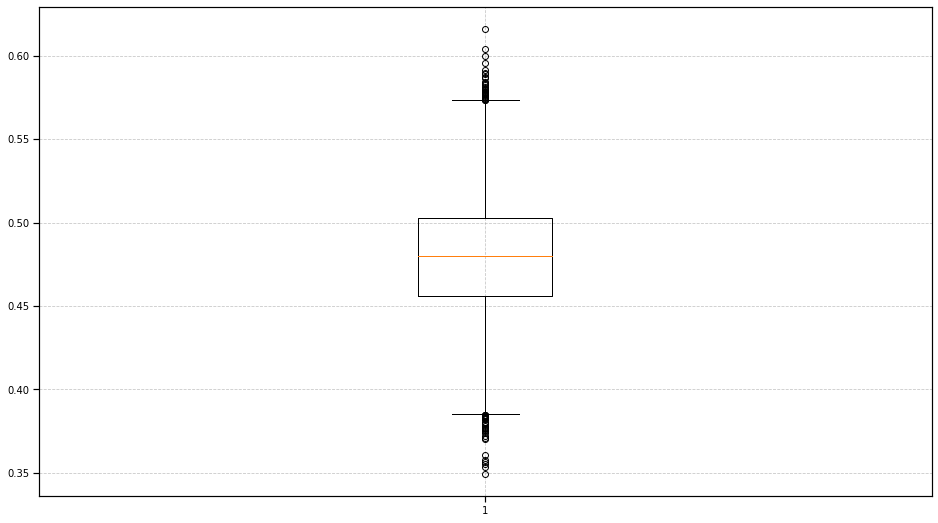

In [28]:
plt.boxplot(lambda_sample)

plt.show()

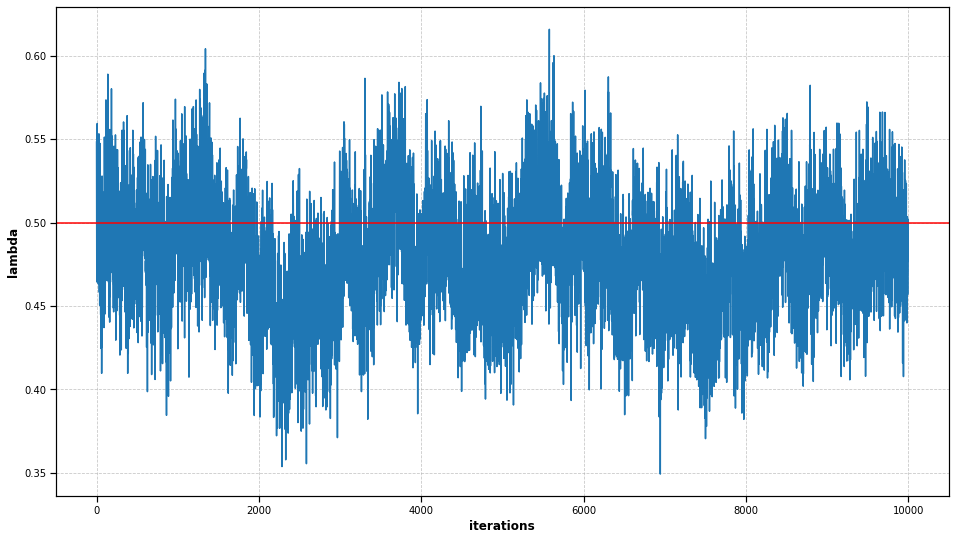

In [39]:
plt.plot(lambda_sample)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.xlabel('iterations')
plt.ylabel('lambda')
plt.show()

In [40]:
len(lambda_sample)

10001

In [41]:
np.mean(lambda_sample) #0.4899961933068114

0.4796759900469165

In [42]:
np.std(lambda_sample) #0.03141620587064071

0.03474148303719757

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [44]:
k = 0.5

In [45]:
noise_level

0.1

In [46]:
mea_sig

0.02520801232409254

In [47]:
alpha

1.0

In [48]:
N_M

5000

In [69]:
#np.save('new_sig01_n1k_alpha05.npy', lambda_sample)
#np.save('noiselv10_n1000_alpha1_nopde_u3.npy', lambda_sample)

In [87]:
np.save('sample_to_plot_new/noiselv10_n5000_alpha1_nopde_u1_1.npy', lambda_sample)

In [49]:
def u_star(x, t):
    return np.sin(x)*np.exp(-k*t)
def du_dx_star(x,t):
    return np.cos(x)*np.exp(-k*t)
def d2u_dxx_star(x,t):
    return -np.sin(x)*np.exp(-k*t)
def du_dt_star(x,t):
    return -k*np.sin(x)*np.exp(-k*t)




In [58]:
from scipy.integrate import dblquad
# Set the integration limits
x_lower = 0
x_upper = np.pi
t_lower = 0
t_upper = 1



def fun_to_int(x,t):
    return (d2u_dxx_star(x,t))**2 

# Perform the double integral
integral_result, _ = dblquad(fun_to_int, t_lower, t_upper, lambda t: x_lower, lambda t: x_upper)
temp = (integral_result + (sig_R2)/(N_M**alpha))
inv_temp = (1/(temp))
Sig_star = ((sig_R2)/(N_M**alpha)) * inv_temp


In [59]:
integral_result

0.9929326518994357

In [60]:
np.sqrt(Sig_star)

0.014190946653957596

In [61]:
k

0.5

In [62]:
theta_sample_star = rng.normal(k, np.sqrt(Sig_star), len(lambda_sample))

In [63]:
theta_sample_star = theta_sample_star.flatten()

In [64]:
import ot

In [65]:
lambda_sample = np.array(lambda_sample)

In [66]:
np.std(lambda_sample)/np.sqrt(Sig_star)

2.44814415023601

In [67]:
ot.wasserstein_1d(lambda_sample, theta_sample_star, p=2)

0.0008412266468341526

In [68]:
ot.emd2_1d(lambda_sample, theta_sample_star, p=2.0)

0.0008412266468341297

In [69]:
np.mean((lambda_sample-k)**2)

0.0016200360241969266

In [70]:
#plt.figure(figsize=(12, 8))

# Plot histogram for s1 without the normal distribution curve
#sns.histplot(lambda_sample, bins=30, kde=False, color='#1f77b4', edgecolor='black', stat="density", label='Sampled Parameter')

# Plot histogram for s2 without the normal distribution curve
#sns.histplot(theta_sample_star, bins=30, kde=False, color='#ff7f0e', edgecolor='black', stat="density", alpha=0.6, label=r'N($\theta^*$, $\Sigma^*$)')

# Customize the plot
#plt.xlabel('Value', fontsize=12)
#plt.ylabel('Density', fontsize=12)
#plt.legend()

# Show the plot
#plt.show()

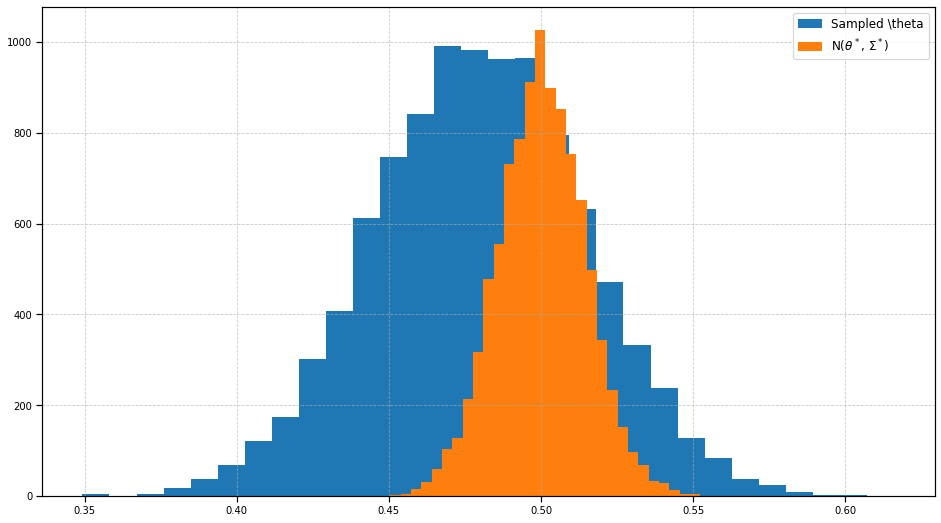

In [71]:
plt.hist(lambda_sample, bins=30, label=r'Sampled \theta')
plt.hist(theta_sample_star, bins = 30, label=r'N($\theta^*$, $\Sigma^*$)')
plt.legend()
plt.show()

In [72]:
ests_u = []
nn_net_i = get_pred_nn()
nn_input_train = np.column_stack([x_vals_sensor, t_vals_sensor])
for ii in trange(len(theta_sample)):
    theta_i = theta_sample[ii] 
    delta_i = delta_sample[ii]
    unflatten_trainable_variables(theta_i, nn_net_i)
    sparse_weight(nn_net_i, delta_i)
    ests_u.append(nn_net_i(nn_input_train))


  0%|          | 0/10001 [00:00<?, ?it/s]

In [73]:
ests_u = np.array(ests_u)
mean_u = np.mean(ests_u,0)
std_u =np.std(ests_u,0)
max_u = np.max(ests_u,0)
min_u = np.min(ests_u,0)
u_est_1sd_top = mean_u + std_u
u_est_1sd_bot = mean_u - std_u


In [74]:
nn_input_train.shape

(5000, 2)

In [75]:
ests_u.shape

(10001, 5000, 1)

In [76]:
mean_u.shape

(5000, 1)

In [77]:
pred_u=mean_u 

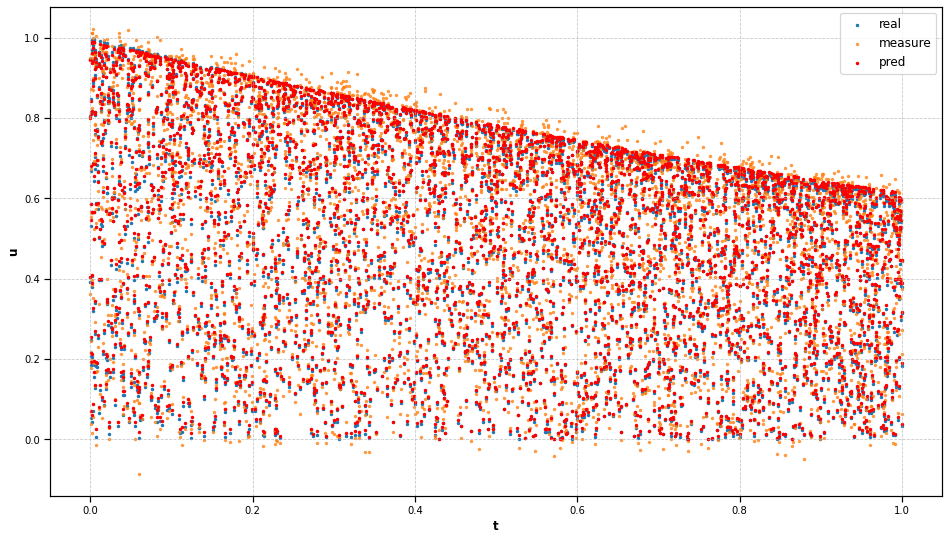

In [78]:
d_show = np.column_stack([t_vals_sensor, u_true, y_obs_int, x_vals_sensor])
d_show = d_show[d_show[:, 0].argsort()] 
plt.scatter(d_show[:,0],d_show[:,1], label="real", s= 5)
plt.scatter(d_show[:,0],d_show[:,2], label="measure", s= 5, alpha = 0.7)
plt.scatter(nn_input_train[:,1], pred_u, label="pred",color='red', s = 5)

plt.xlabel('t')
plt.ylabel('u')
pyplot.legend()

In [79]:
mean_squared_error(pred_u.flatten(), u_true)

<tf.Tensor: shape=(), dtype=float64, numpy=3.031488059523648e-05>

In [80]:
ests_u.shape

(10001, 5000, 1)

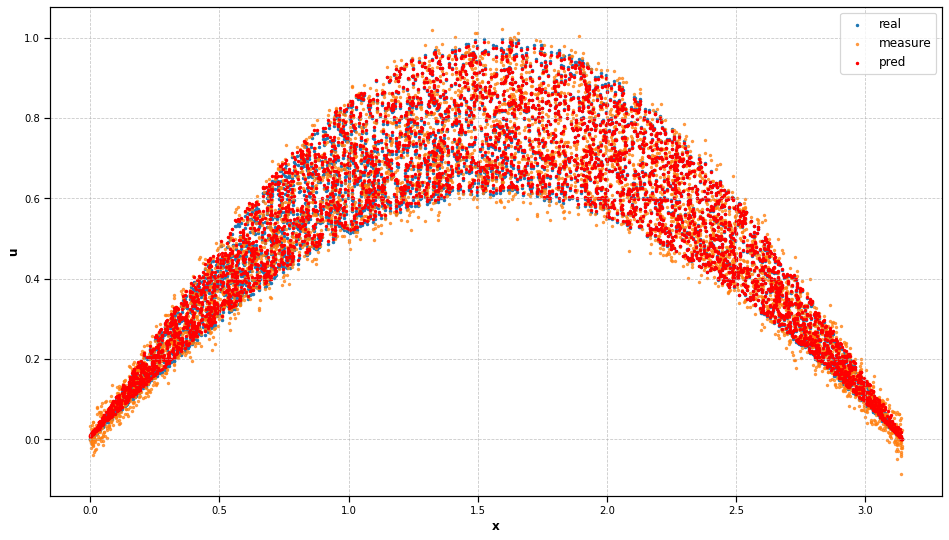

In [81]:
d_show = np.column_stack([t_vals_sensor, u_true, y_obs_int, x_vals_sensor, pred_u])
d_show = d_show[d_show[:, 3].argsort()] 
plt.scatter(d_show[:,3],d_show[:,1], label="real", s= 5)
plt.scatter(d_show[:,3],d_show[:,2], label="measure", s= 5, alpha = 0.7)
plt.scatter(d_show[:,3], d_show[:,4], label="pred",color='red', s = 5)

plt.xlabel('x')
plt.ylabel('u')
pyplot.legend()

In [82]:
def evalue_u_with_grad(nn_input_test, nn_net_i):
    tf_input_test = tf.Variable(nn_input_test, trainable=True)
    with tf.GradientTape(persistent=True) as t_2:
        with tf.GradientTape(persistent=True) as t_1:
            u_W = nn_net_i(tf_input_test)
        du_xt_W = t_1.gradient(u_W, tf_input_test)
        du_dt_W = du_xt_W[:,1]
        du_dx_W = du_xt_W[:,0]
    du_dxdx_W = t_2.gradient(du_dx_W, tf_input_test)[:, 0]
    del t_1, t_2
    u_true =  u_star(nn_input_test[:,0], nn_input_test[:,1])

    return np.squeeze(u_W), np.squeeze(du_dt_W), np.squeeze(du_dxdx_W), u_true

In [83]:
def test_score(theta_sample, delta_sample, batch_size=5000):
    mm = int(10000)
    x_vals = rng.uniform(0, np.pi, mm)
    t_vals = rng.uniform(0, 1, mm)
    nn_input_test = np.column_stack([x_vals, t_vals])
    
    # Initialize a list to hold batched predictions

    rho_f_W = []
    
    for ii in trange(len(theta_sample)):
        nn_net_i = get_pred_nn()
        theta_i = theta_sample[ii]
        delta_i = delta_sample[ii]
        unflatten_trainable_variables(theta_i, nn_net_i)
        sparse_weight(nn_net_i, delta_i)
        
        # Process in batches
        u_W_all = []
        du_dt_W_all = []
        du_dxdx_W_all = []
        u_true_all = []
        u_t_true_all = []


        for batch_start in range(0, mm, batch_size):
            batch_end = min(batch_start + batch_size, mm)
            nn_input_batch = nn_input_test[batch_start:batch_end]
            u_W, du_dt_W, du_dxdx_W, u_true = evalue_u_with_grad(nn_input_batch, nn_net_i)
            u_W_all.append(u_W)
            du_dt_W_all.append(du_dt_W)
            du_dxdx_W_all.append(du_dxdx_W)
            u_true_all.append(u_true)
        
        

        u_W_all = np.concatenate(u_W_all)
        du_dt_W_all = np.concatenate(du_dt_W_all)
        du_dxdx_W_all = np.concatenate(du_dxdx_W_all)
        u_true_all = np.concatenate(u_true_all)
        
    
        temp_l2_diff_u = np.mean((u_W_all-u_true_all)**2)
        
        l2_u_t_W = np.mean((du_dt_W_all)**2)
        Phi_W = np.mean(du_dt_W_all*du_dxdx_W_all)
        Sig_W_inv =  1 / (np.mean((du_dxdx_W_all)**2) + mea_sig**2 / N_M)
        pde_l2_diff = l2_u_t_W - Phi_W*Sig_W_inv*Phi_W
        rho_est1 = np.sqrt(temp_l2_diff_u + pde_l2_diff)
        
        rho_f_W.append(rho_est1)

    

    
    return rho_f_W


In [84]:
rho_f_W = test_score(theta_sample, delta_sample) 

  0%|          | 0/10001 [00:00<?, ?it/s]

In [85]:
np.mean(rho_f_W) #

0.04982401747328862

In [86]:
np.std(rho_f_W) #

0.009852680307374436